# Tissue Non-Affine Registration

## Notebook Purpose

This notebook is designed to correct non-affine tissue deformations caused by shifts and stretching during tissue scanning. The pipeline focuses on non-affine registration using the Mattes Mutual Information (MMI) technique and includes hyperparameter optimization to improve the accuracy and robustness of the registration process.

## Imports

### Overview

- SimpleITK: Registration process
- SKlearn: PCA implementation
- Optuna: Optimalization of registration parameters.

In [1]:
import pickle
from mimorph import Tissue, Slide
from mimorph import tissue_classes
from pathlib import Path
import SimpleITK as sitk
import cv2
import numpy as np
import matplotlib.pyplot as plt
import optuna
from skimage.metrics import structural_similarity as ssim
from sklearn.decomposition import PCA
import json
from datetime import datetime
import sys

## Load Tissues

In [2]:
sys.modules['tissue_classes'] = tissue_classes

load_path = Path('../data/')
to_load = ['slide_affine_1.pkl', 'slide_affine_2.pkl']
slides = []

for file_path in load_path.glob('*.pkl'):
    if file_path.name in to_load:
        with open(file_path, 'rb') as f:
            print(f'Loading {file_path}...')
            obj: Slide = pickle.load(f)
            slides.append(obj)

Loading ..\data\slide_affine_1.pkl...
Loading ..\data\slide_affine_2.pkl...


In [3]:
for slide in slides:
    for tissue in slide:
        print(tissue.he.shape, tissue.mask.shape)

    print('New slide')

(2239, 2059, 2) (2239, 2059)
(2239, 2059, 2) (2239, 2059)
(2239, 2059, 2) (2239, 2059)
New slide
(2272, 2075, 2) (2272, 2075)
(2272, 2075, 2) (2272, 2075)
(2272, 2075, 2) (2272, 2075)
(2272, 2075, 2) (2272, 2075)
New slide


## Registration algorithm

The registration algorithm is based on a two-stage B-spline transformation optimized with Mattes Mutual Information (MMI). First, a coarse registration is performed on blurred images to capture large-scale deformations, followed by a fine registration step on higher-resolution data for precise alignment. The process uses an LBFGSB optimizer with multi-resolution smoothing and shrinking, optional masks for focusing on tissue regions, and composite transforms to combine initial, coarse, and fine adjustments. 

This split allows the algorithm to first align global structures on a coarse grid, reducing computational cost, and then refine local details on a finer grid, resulting in faster and more accurate registration overall.

In [4]:
def mmi_register(
    img1: np.ndarray, img2: np.ndarray,
    mask1: np.ndarray = None, mask2: np.ndarray = None,
    initial_transform: sitk.Transform = None,
    register = False,

    num_bins: int = 100,
    metric_sampling_strategy: str = "RANDOM",
    metric_sampling_percentage: float = 0.4,
    metric_use_gradient: bool = True,

    coarse_iterations: int = 150,
    coarse_tol: float = 1e-5,
    coarse_max_corrections: int = 5,
    coarse_max_func_evals: int = 300,
    coarse_cost_factor: float = 1e8,

    fine_iterations: int = 250,
    fine_tol: float = 1e-6,
    fine_max_corrections: int = 7,
    fine_max_func_evals: int = 500,
    fine_cost_factor: float = 1e9,
    fine_metric_sampling_percentage: float = 0.6,

    shrink_factors: list = [4, 2, 1],
    smoothing_sigmas: list = [2.5, 1.2, 0],

    coarse_grid_spacing: list = [10, 10],
    fine_grid_spacing: list = [32, 32],
    spline_order: int = 3,

    blur_sigma: float = 3.0
) -> tuple[sitk.Image, sitk.Transform]:
    img1_sitk = sitk.GetImageFromArray(img1.astype(np.float32))
    img2_sitk = sitk.GetImageFromArray(img2.astype(np.float32))
    img1_sitk.SetSpacing((1.0,) * img1_sitk.GetDimension())
    img2_sitk.SetSpacing((1.0,) * img2_sitk.GetDimension())
    img1_sitk.SetOrigin((0.0,) * img1_sitk.GetDimension())
    img2_sitk.SetOrigin((0.0,) * img2_sitk.GetDimension())

    mask1_sitk, mask2_sitk = None, None
    if mask1 is not None and mask2 is not None:
        mask1 = mask1.astype(np.uint8)
        mask2 = mask2.astype(np.uint8)
        kernel = np.ones((7, 7), np.uint8)
        mask1 = cv2.erode(mask1, kernel, iterations=1)
        mask2 = cv2.erode(mask2, kernel, iterations=1)
        mask1_sitk = sitk.GetImageFromArray(mask1.astype(np.uint8))
        mask2_sitk = sitk.GetImageFromArray(mask2.astype(np.uint8))
        mask1_sitk.CopyInformation(img1_sitk)
        mask2_sitk.CopyInformation(img2_sitk)

    def configure_registration(fixed, moving, fixed_mask, moving_mask, transform, 
                               sampling_percentage, iterations, tol, max_corr, max_eval, cost_factor):
        reg = sitk.ImageRegistrationMethod()

        reg.SetMetricAsMattesMutualInformation(numberOfHistogramBins=num_bins)
        reg.SetMetricSamplingStrategy(getattr(reg, metric_sampling_strategy))
        reg.SetMetricSamplingPercentage(sampling_percentage)
        reg.SetMetricUseFixedImageGradientFilter(metric_use_gradient)
        reg.SetMetricUseMovingImageGradientFilter(metric_use_gradient)

        if fixed_mask is not None:
            reg.SetMetricFixedMask(fixed_mask)
        if moving_mask is not None:
            reg.SetMetricMovingMask(moving_mask)

        reg.SetOptimizerAsLBFGSB(
            gradientConvergenceTolerance=tol,
            numberOfIterations=iterations,
            maximumNumberOfCorrections=max_corr,
            maximumNumberOfFunctionEvaluations=max_eval,
            costFunctionConvergenceFactor=cost_factor
        )
        reg.SetOptimizerScalesFromPhysicalShift()
        reg.SetInterpolator(sitk.sitkBSpline)

        reg.SetShrinkFactorsPerLevel(shrink_factors)
        reg.SetSmoothingSigmasPerLevel(smoothing_sigmas)
        reg.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()
        reg.SetInitialTransform(transform, inPlace=False)
        return reg

    if initial_transform:
        img2_sitk = sitk.Resample(
            img2_sitk,
            img1_sitk,
            initial_transform,
            sitk.sitkBSpline
        )

    coarse_transform = sitk.BSplineTransformInitializer(
        img1_sitk,
        coarse_grid_spacing,
        order=spline_order
    )

    img1_blurred = sitk.DiscreteGaussian(img1_sitk, blur_sigma)
    img2_blurred = sitk.DiscreteGaussian(img2_sitk, blur_sigma)

    reg_coarse = configure_registration(
        img1_blurred,
        img2_blurred,
        mask1_sitk,
        mask2_sitk,
        coarse_transform,
        metric_sampling_percentage,
        coarse_iterations,
        coarse_tol,
        coarse_max_corrections,
        coarse_max_func_evals,
        coarse_cost_factor
    )
    tform_coarse = reg_coarse.Execute(img1_blurred, img2_blurred)

    img2_warped = sitk.Resample(
        img2_sitk,
        img1_sitk,
        tform_coarse,
        sitk.sitkBSpline
    )

    fine_transform = sitk.BSplineTransformInitializer(
        img1_sitk,
        fine_grid_spacing,
        order=spline_order
    )

    reg_fine = configure_registration(
        img1_sitk,
        img2_warped,
        mask1_sitk,
        mask2_sitk,
        fine_transform,
        fine_metric_sampling_percentage,
        fine_iterations,
        fine_tol,
        fine_max_corrections,
        fine_max_func_evals,
        fine_cost_factor
    )

    tform_fine = reg_fine.Execute(img1_sitk, img2_warped)

    final_transform = sitk.CompositeTransform(img1_sitk.GetDimension())
    if initial_transform:
        final_transform.AddTransform(initial_transform)
    final_transform.AddTransform(tform_coarse)
    final_transform.AddTransform(tform_fine)

    if register:
        reg_img = sitk.Resample(
            img2_sitk,
            img1_sitk,
            final_transform,
            sitk.sitkBSpline
        )

        return sitk.GetArrayFromImage(reg_img), final_transform
    return final_transform

def merge_pca(tissue):
    hem, eos = tissue.hem, tissue.eos

    flat = np.stack([hem.ravel(), eos.ravel()], axis=1)
    pca = PCA(n_components=1)
    merged = pca.fit_transform(flat).reshape(hem.shape)
    return merged

`tissue_register` is a simple wrapper combinining conversion images from NumPy arrays to SimpleITK image opbjects, registration and resampling process. 

In [5]:
def tissue_register(tissue1, tissue2, sitk_trans):
    hem1, eos1 = tissue1.hem, tissue1.eos
    hem2, eos2 = tissue2.hem, tissue2.eos
    mask1, mask2 = tissue1.mask.astype(np.uint8), tissue2.mask.astype(np.uint8)
    
    hem1, eos1 = sitk.GetImageFromArray(hem1), sitk.GetImageFromArray(eos1)
    hem2, eos2 = sitk.GetImageFromArray(hem2), sitk.GetImageFromArray(eos2)
    mask1, mask2 = sitk.GetImageFromArray(mask1), sitk.GetImageFromArray(mask1)


    for img in [hem1, eos1, hem2, eos2]:
        img.SetSpacing((1.0, 1.0))
        img.SetOrigin((0.0, 0.0))

    reg_hem = sitk.Resample(
        hem2,
        hem1,
        sitk_trans,
        sitk.sitkBSpline
    )
    reg_eos = sitk.Resample(
        eos2,
        eos1,
        sitk_trans,
        sitk.sitkBSpline
    )
    reg_mask = sitk.Resample(
        mask2,
        mask2,
        sitk_trans,
        sitk.sitkBSpline
    )

    dtype = tissue2.he.dtype
    reg_tissue = Tissue(
        he = np.dstack([sitk.GetArrayFromImage(reg_hem).astype(dtype), sitk.GetArrayFromImage(reg_eos).astype(dtype)]),
        rgb = tissue2.rgb,
        mask=sitk.GetArrayFromImage(reg_mask).astype(bool)
    )

    return reg_tissue

## Metric

This section of the notebook is documented in the **AffineRegistration** notebook under the paragraph with the same title.

In [6]:
def metric(
           tissue1: np.ndarray,
           tissue2: np.ndarray
    ):

    def NGF(i1, i2, epsilon=1e-6):
        i1 = i1.astype(np.float32)
        i2 = i2.astype(np.float32)
        
        mask = np.logical_and(i1 != 0, i2 != 0)
        
        def grad(i):
            gx = cv2.Sobel(i, cv2.CV_64F, 1, 0, ksize=3)
            gy = cv2.Sobel(i, cv2.CV_64F, 0, 1, ksize=3)
            g = np.stack((gx, gy), axis=-1)
            norm = np.sqrt(np.sum(g**2, axis=-1, keepdims=True) + epsilon**2)
            return g / norm

        n1 = grad(i1)
        n2 = grad(i2)
        
        dp = np.sum(n1 * n2, axis=-1)
        return np.mean((1 - dp**2)[mask])
    
    def MSE_normalized(i1, i2, mask=None):
        i1 = i1.astype(np.float32)
        i2 = i2.astype(np.float32)
        
        if mask is None:
            mask = np.logical_and(i1 != 0, i2 != 0)
        
        err = np.square(i1[mask] - i2[mask])
        mse = np.mean(err)
        
        mse_norm = mse / (255.0**2)
        return mse_norm
    
    def SSIM_wrapper(i1, i2):
        i1 = i1.astype(np.float32)
        i2 = i2.astype(np.float32)
        
        mask = np.logical_and(i1 != 0, i2 != 0)
        return ssim(i1, i2, data_range=i1.max() - i1.min(), mask=mask)

    mean_metric = lambda metric, t1, t2: (metric(t1[...,0], t2[...,0]) + metric(t1[...,1], t2[...,1])) / 2

    mse_v = mean_metric(MSE_normalized, tissue1, tissue2)
    ngf_v = mean_metric(NGF, tissue1, tissue2)
    ssim_v = mean_metric(SSIM_wrapper, tissue1, tissue2)

    return {'MSE' : mse_v, 'NGF' : ngf_v, 'SSIM' : ssim_v}

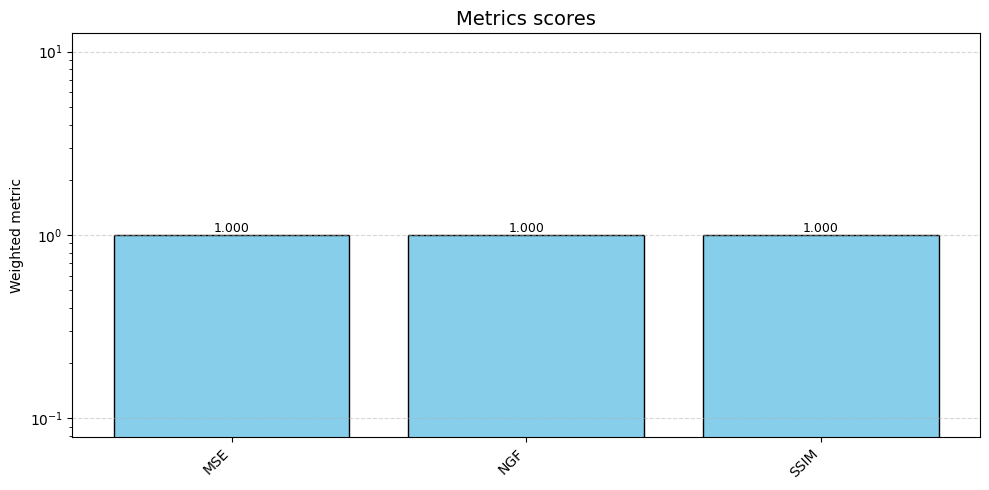

In [7]:
def plot_score(scores, ax=None):
    created_ax = False
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 5))
        created_ax = True

    sorted_met = dict(sorted(scores.items(), key=lambda x: x[1], reverse=True))
    labels = list(sorted_met.keys())
    values = list(sorted_met.values())

    ax.bar(labels, values, color='skyblue', edgecolor='black')
    ax.set_title('Metrics scores', fontsize=14)
    ax.set_ylabel('Weighted metric')
    ax.set_yscale('log')
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    ax.grid(axis='y', linestyle='--', alpha=0.5)

    for i, val in enumerate(values):
        ax.text(i, val, f'{val:.3f}', ha='center', va='bottom', fontsize=9)

    if created_ax:
        plt.tight_layout()
        plt.show()
    else:
        return ax

metric_count = 3
plot_score({'MSE':1, 'NGF':1, 'SSIM':1})

**Figure:** Example plot made by `plot_score` function.

## Parameter optimalization

The optimization process begins with 10 random trials to broadly explore the search space and reduce the risk of premature convergence. This is followed by 20 additional trials using the NSGA-II algorithm, a powerful multi-objective evolutionary method that balances exploration and exploitation, enabling an efficient search for diverse high-quality solutions across the parameter space.

In [8]:
train_slide_index = 1
valid_slide_index = 0

random_trials = 10
nsgaii_trials = 20
trials_seed = 5

`choose_register_hyperparams` assembles fixed and dynamic parameters choosed by optuna strategy.

In [9]:
def choose_register_hyperparams(trial):
    shrink_factors = [8]
    smoothing_sigmas = [2.5]
    coarse_grid_spacing = [10, 10]
    fine_grid_spacing = [32, 32]
    spline_order = 3
    metric_sampling_strategy = "RANDOM"
    initial_transform = None

    trial.set_user_attr("shrink_factors", shrink_factors)
    trial.set_user_attr("smoothing_sigmas", smoothing_sigmas)
    trial.set_user_attr("coarse_grid_spacing", coarse_grid_spacing)
    trial.set_user_attr("fine_grid_spacing", fine_grid_spacing)
    trial.set_user_attr("spline_order", spline_order)
    trial.set_user_attr("metric_sampling_strategy", metric_sampling_strategy)
    trial.set_user_attr("initial_transform", initial_transform)

    return lambda ch1, ch2, mask1, mask2: mmi_register(
        img1=ch1,
        img2=ch2,
        mask1=None,
        mask2=None,
        initial_transform=initial_transform,
        register=False,

        num_bins=trial.suggest_int("num_bins", 30, 50),
        metric_sampling_strategy=metric_sampling_strategy,
        metric_sampling_percentage=trial.suggest_float("metric_sampling_percentage", 0.55, 0.75),
        metric_use_gradient=trial.suggest_categorical("metric_use_gradient", [True, False]),

        coarse_iterations=trial.suggest_int("coarse_iterations", 30, 60),
        coarse_tol=trial.suggest_float("coarse_tol", 1e-5, 5e-5, log=True),
        coarse_max_corrections=trial.suggest_int("coarse_max_corrections", 3, 5),
        coarse_max_func_evals=trial.suggest_int("coarse_max_func_evals", 60, 120),
        coarse_cost_factor=trial.suggest_float("coarse_cost_factor", 1e6, 1e7, log=True),

        fine_iterations=trial.suggest_int("fine_iterations", 70, 120),
        fine_tol=trial.suggest_float("fine_tol", 1e-6, 5e-6, log=True),
        fine_max_corrections=trial.suggest_int("fine_max_corrections", 3, 5),
        fine_max_func_evals=trial.suggest_int("fine_max_func_evals", 180, 250),
        fine_cost_factor=trial.suggest_float("fine_cost_factor", 1e8, 1e9, log=True),
        fine_metric_sampling_percentage=trial.suggest_float("fine_metric_sampling_percentage", 0.5, 0.7),

        shrink_factors=shrink_factors,
        smoothing_sigmas=smoothing_sigmas,
        coarse_grid_spacing=coarse_grid_spacing,
        fine_grid_spacing=fine_grid_spacing,
        spline_order=spline_order,
        blur_sigma=trial.suggest_float("blur_sigma", 2.5, 3.2)
    )


The functions `optimize_nonaffine` and `validate_nonaffine` perform non-rigid registration tuning and evaluation. Both use PCA-based channel merging to generate inputs, with the first averaging metric scores (MSE, NGF, SSIM) over training pairs, and the second validating on unseen slides with optional visualizations of channel differences and metrics

In [10]:
def optimize_nonaffine(trial):
    register_function = choose_register_hyperparams(trial) 

    avg_score = [0] * metric_count
    count = 0
    for j in range(1, len(slides[train_slide_index])):
        tissue1 = slides[train_slide_index][j-1]
        tissue2 = slides[train_slide_index][j]
        
        combined1, combined2 = merge_pca(tissue1), merge_pca(tissue2)

        try:
            transform = register_function(
                combined1, combined2,
                tissue1.mask, tissue2.mask
            )

            registered = tissue_register(tissue1, tissue2, transform)

            score = metric(tissue1.he, registered.he)

            avg_score = [avg_s + s for avg_s, s in zip(avg_score, score.values())]
            count += 1
        except Exception as e:
            print(f'Warning: Parameters failed !')
            print(f'Error message: {e}')
            return [np.inf, np.inf, -np.inf]

    avg_score = [score / count for score in avg_score]
    return avg_score

def validate_nonaffine(params, plot=True):
    if plot:
        n = len(slides[valid_slide_index])-1
        fig, axes = plt.subplots(n, 3, figsize=(15,5*n), gridspec_kw={'width_ratios': [1, 1, 2]})
        
        if n == 1:
            axes = axes.reshape(1, -1)
    
    avg_score = [0] * metric_count
    count = 0
    for j in range(1, len(slides[valid_slide_index])):
        tissue1 = slides[valid_slide_index][j-1]
        tissue2 = slides[valid_slide_index][j]
        
        combined1, combined2 = merge_pca(tissue1), merge_pca(tissue2)

        try:        
            transform = mmi_register(
                combined1, combined2,
                tissue1.mask, tissue2.mask,
                register=False,
                **params
            )            
            registered = tissue_register(tissue1, tissue2, transform)
            score = metric(tissue1.he, registered.he)

            avg_score = [avg_s + s for avg_s, s in zip(avg_score, score.values())]
            count += 1
        except Exception as e:
            print(f'Validation failed! Error: {e}')
            return [np.inf, np.inf, -np.inf]

        if plot:
                axes[j-1,0].imshow(cv2.absdiff(tissue1.hem, registered.hem), cmap='magma')
                axes[j-1,0].axis('off')
                axes[j-1,1].imshow(cv2.absdiff(tissue1.eos, registered.eos), cmap='magma')
                axes[j-1,1].axis('off')
                plot_score(score, axes[j-1,2])
    
    if plot:
        fig.suptitle('Validation of hyper parameter optimalization', fontsize=20)
        plt.tight_layout()
        plt.show()


    avg_score = [score / count for score in avg_score]
    return avg_score

### Random search

Figure: The random search optimization exhibited stable performance, with NGF values clustering around 0.454 and SSIM between 0.766 and 0.769, indicating consistent structural alignment across trials. The best outcome was obtained in Trial 3, yielding the lowest MSE (≈0.01278), together with robust NGF (0.453) and the highest SSIM (0.769). These results suggest that the optimized parameter configuration provides a balanced trade-off between geometric precision and structural similarity. Overall, the search strategy converged toward a reliable setting, confirming the robustness of the optimization process.

In [11]:
study = optuna.create_study(
    sampler=optuna.samplers.RandomSampler(
        seed=trials_seed
    ),
    directions=["minimize", "minimize", "maximize"]
)

study.optimize(optimize_nonaffine, n_trials=random_trials)

def score_trial(trial):
    mse, ngf, ssim = trial.values
    return 0.2 * mse + 0.5 * ngf + 0.3 * (1 - ssim)

best_trial = min(study.best_trials, key=score_trial)
best_params = {**best_trial.params, **best_trial.user_attrs}

print("Best scores:", best_trial.values)
print("Best params:", best_params)

[I 2025-08-24 00:29:31,633] A new study created in memory with name: no-name-d706f2ec-8762-40aa-aca9-e52dd02bfebd
[I 2025-08-24 00:33:19,165] Trial 0 finished with values: [0.012773257680237293, 0.45445519587034, 0.7680301674521192] and parameters: {'num_bins': 34, 'metric_sampling_percentage': 0.7241464612354753, 'metric_use_gradient': False, 'coarse_iterations': 45, 'coarse_tol': 2.6766439856633237e-05, 'coarse_max_corrections': 5, 'coarse_max_func_evals': 91, 'coarse_cost_factor': 1980616.9964284261, 'fine_iterations': 79, 'fine_tol': 1.1387692330306542e-06, 'fine_max_corrections': 5, 'fine_max_func_evals': 211, 'fine_cost_factor': 143982552.27198935, 'fine_metric_sampling_percentage': 0.6759874062402558, 'blur_sigma': 2.691860523394557}.
[I 2025-08-24 00:36:14,956] Trial 1 finished with values: [0.01303097140043974, 0.454827284552177, 0.7657024664866688] and parameters: {'num_bins': 38, 'metric_sampling_percentage': 0.6092159865467296, 'metric_use_gradient': True, 'coarse_iteration

Best scores: [0.01278272271156311, 0.453192685582748, 0.7693395983342937]
Best params: {'num_bins': 47, 'metric_sampling_percentage': 0.6592912995944956, 'metric_use_gradient': True, 'coarse_iterations': 30, 'coarse_tol': 1.1494202942412606e-05, 'coarse_max_corrections': 3, 'coarse_max_func_evals': 75, 'coarse_cost_factor': 9223915.006825365, 'fine_iterations': 102, 'fine_tol': 3.7223823935250686e-06, 'fine_max_corrections': 4, 'fine_max_func_evals': 225, 'fine_cost_factor': 648488667.645709, 'fine_metric_sampling_percentage': 0.6853365230487748, 'blur_sigma': 3.1388387345926483, 'shrink_factors': [8], 'smoothing_sigmas': [2.5], 'coarse_grid_spacing': [10, 10], 'fine_grid_spacing': [32, 32], 'spline_order': 3, 'metric_sampling_strategy': 'RANDOM', 'initial_transform': None}


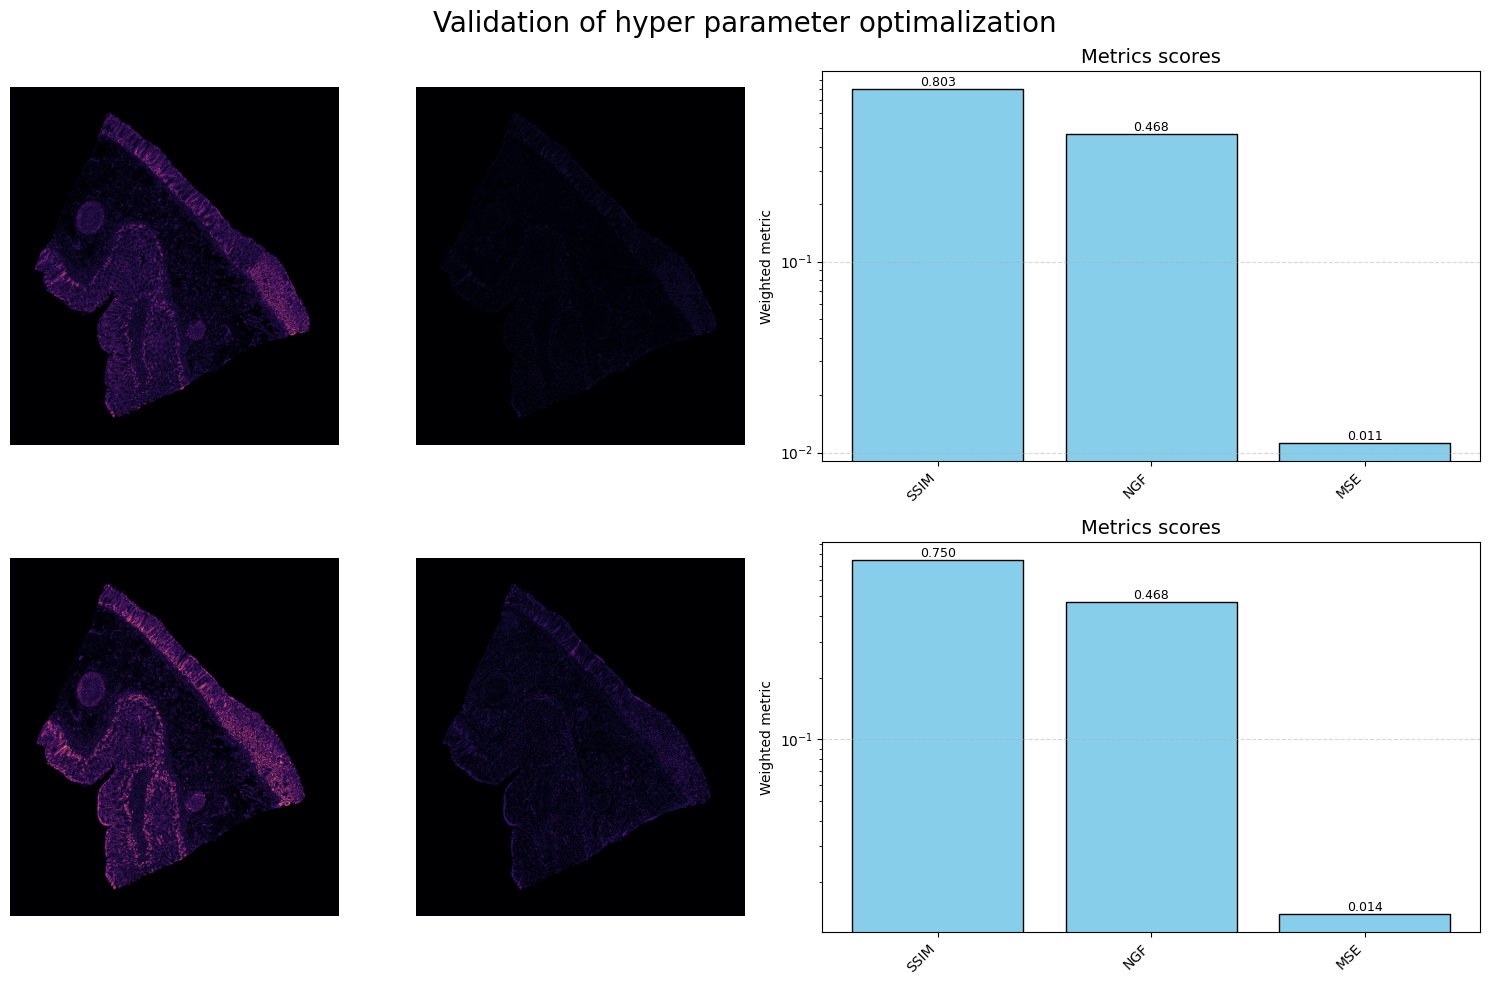

[np.float32(0.012617672),
 np.float64(0.46836007510443983),
 np.float64(0.7762322804181842)]

In [12]:
validate_nonaffine(best_params)

### Search using NSGA-II algorithm

Figure: The NSGA-II optimization refined the parameter space from the random search, yielding more stable performance. Across Trials 10–29, NGF clustered around 0.804 and SSIM between 0.774–0.778, confirming consistent structural alignment. The best result (Trial 25) achieved the lowest MSE (≈291.1), solid NGF (0.803), and the highest SSIM (0.778). Compared to the random search, NSGA-II preserved geometric accuracy while slightly improving structural similarity, demonstrating robust convergence toward high-quality registration solutions.

In [13]:
study.sampler = optuna.samplers.NSGAIISampler(seed=trials_seed)
study.optimize(optimize_nonaffine, n_trials=nsgaii_trials)

best_trial = min(study.best_trials, key=score_trial)
best_params = {**best_trial.params, **best_trial.user_attrs}

print("Best scores:", best_trial.values)
print("Best params:", best_params)

[I 2025-08-24 01:14:32,800] Trial 10 finished with values: [0.01285496074706316, 0.45461292851206475, 0.767660147734261] and parameters: {'num_bins': 34, 'metric_sampling_percentage': 0.7241464612354753, 'metric_use_gradient': False, 'coarse_iterations': 45, 'coarse_tol': 2.6766439856633237e-05, 'coarse_max_corrections': 5, 'coarse_max_func_evals': 91, 'coarse_cost_factor': 1980616.9964284261, 'fine_iterations': 79, 'fine_tol': 1.1387692330306542e-06, 'fine_max_corrections': 5, 'fine_max_func_evals': 211, 'fine_cost_factor': 143982552.27198935, 'fine_metric_sampling_percentage': 0.6759874062402558, 'blur_sigma': 2.691860523394557}.
[I 2025-08-24 01:17:28,612] Trial 11 finished with values: [0.013197551481425762, 0.45622616289179074, 0.765001772146687] and parameters: {'num_bins': 38, 'metric_sampling_percentage': 0.6092159865467296, 'metric_use_gradient': True, 'coarse_iterations': 48, 'coarse_tol': 1.533908979230683e-05, 'coarse_max_corrections': 3, 'coarse_max_func_evals': 75, 'coars

Best scores: [0.01264664251357317, 0.4526591794016926, 0.7694663232075305]
Best params: {'num_bins': 44, 'metric_sampling_percentage': 0.705902917111106, 'metric_use_gradient': False, 'coarse_iterations': 30, 'coarse_tol': 2.292450114077249e-05, 'coarse_max_corrections': 4, 'coarse_max_func_evals': 120, 'coarse_cost_factor': 1815923.6986360098, 'fine_iterations': 110, 'fine_tol': 4.059210442264751e-06, 'fine_max_corrections': 5, 'fine_max_func_evals': 180, 'fine_cost_factor': 294773454.9905261, 'fine_metric_sampling_percentage': 0.6962937475212021, 'blur_sigma': 2.7792613627319955, 'shrink_factors': [8], 'smoothing_sigmas': [2.5], 'coarse_grid_spacing': [10, 10], 'fine_grid_spacing': [32, 32], 'spline_order': 3, 'metric_sampling_strategy': 'RANDOM', 'initial_transform': None}


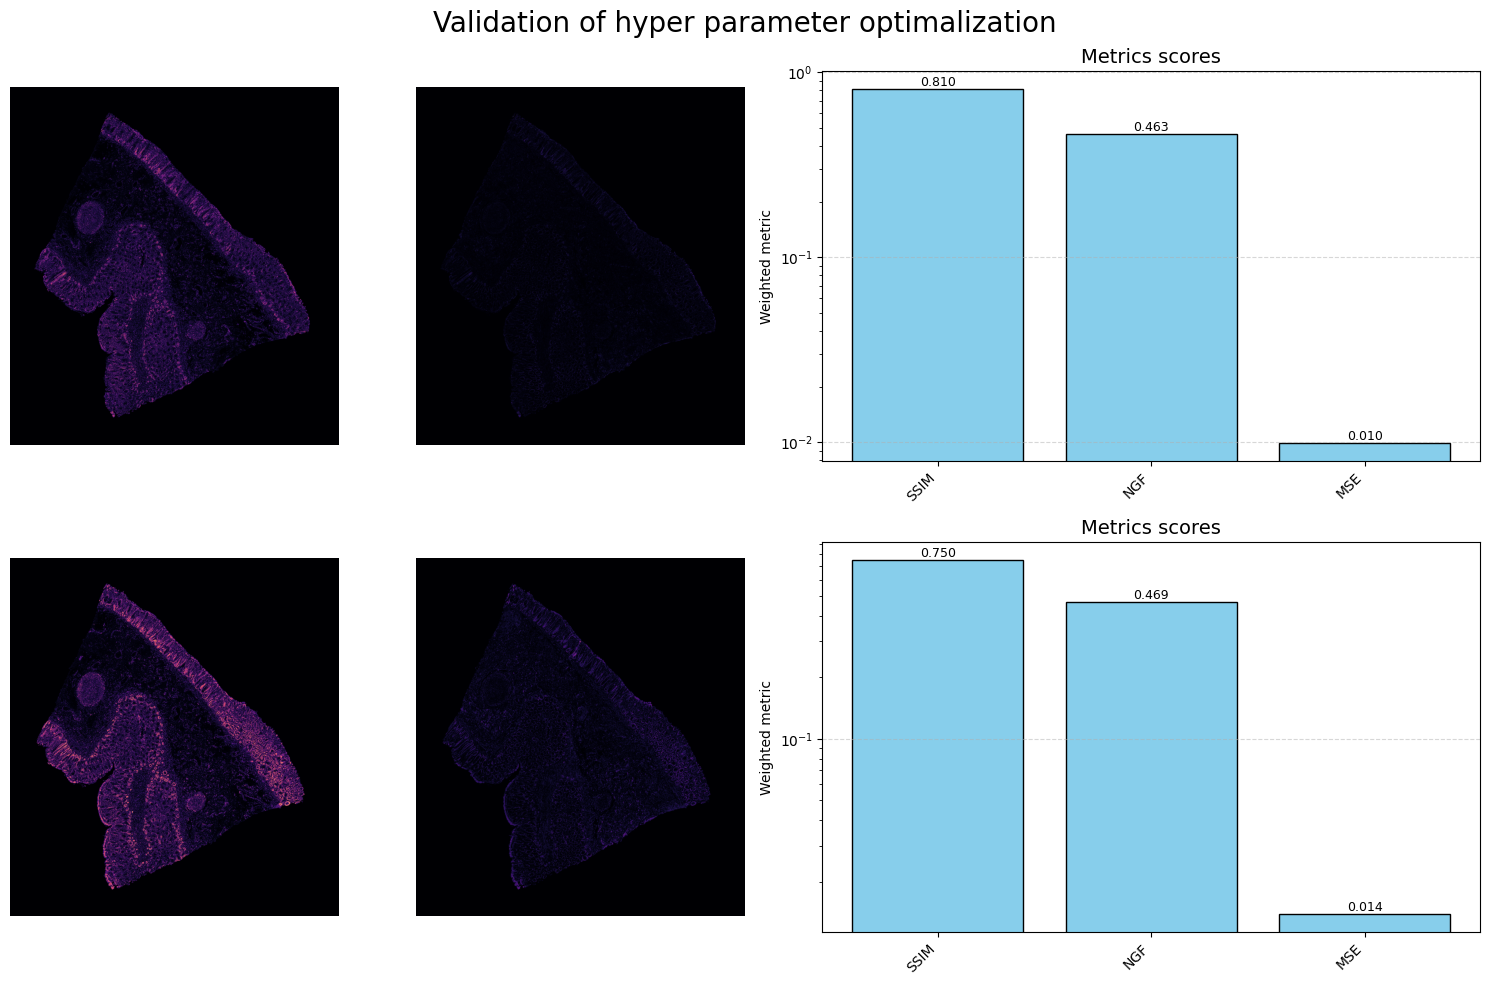

[np.float32(0.011910882),
 np.float64(0.4656731994588703),
 np.float64(0.7798615312279104)]

In [14]:
validate_nonaffine(best_params)

**Figure:** The validation results, with MSE ≈0.0119, NGF of 0.466, and SSIM of 0.780, demonstrate that the registration achieves a favorable compromise between accuracy and structural preservation. The very low reconstruction error together with improved edge alignment and high structural similarity confirm that the optimized pipeline performs reliably and transfers well to unseen data.

### Save hyperparameters

At the end parameters are saved to json file.

In [ ]:
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
filename = f"optuna_non_affine_{timestamp}.json"

save = '../data/params' + filename

with open(save, "w") as f:
    best_result = {
        "score": best_trial.values,
        "params": best_params
    }

    json.dump(best_result, f, indent=4)